In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

In [17]:
# Pull in hcdn_q_data from streamflowdata folder
hcdn_q_data = xr.open_dataset('../data/streamflowdata/hcdn_q_data.nc')

# add a water year variable to the dataset
hcdn_q_data['water_year'] = hcdn_q_data.datetime.dt.year.where(hcdn_q_data.datetime.dt.month >= 10, hcdn_q_data.datetime.dt.year - 1)

# create a function to calculate the day of water year for each date in the dataset
def day_of_water_year_func(date):
    if date.month >= 10:
        return (date - pd.to_datetime(str(date.year) + '-10-01')).days + 1
    else:
        return (date - pd.to_datetime(str(date.year - 1) + '-10-01')).days + 1

# apply the function to the datetime variable to create a new variable
day_of_water_year = [day_of_water_year_func(date) for date in pd.to_datetime(hcdn_q_data.datetime.values)]

# add the day of water year variable to the dataset
hcdn_q_data['day_of_water_year'] = xr.DataArray(day_of_water_year, dims=['datetime'], coords={'datetime': hcdn_q_data.datetime})
                                                

In [20]:
# calculate the day of water year flow at each site
water_year_mean_flow = hcdn_q_data.groupby('day_of_water_year').mean()['00060_Mean']


In [23]:
# calculate the cumulative distribution of flow at each site
water_year_mean_flow_cum_dist = water_year_mean_flow.rank(dim='day_of_water_year',pct=True)
water_year_mean_flow_cum_dist

ModuleNotFoundError: No module named 'bottleneck'

In [33]:
# calculate the cumulative distribution of flow at one site using pandas 
# (this is just to check that the xarray method is working correctly)
water_year_mean_flow_cum_dist_pandas = pd.DataFrame(water_year_mean_flow.values/water_year_mean_flow.sum(), index=water_year_mean_flow.day_of_water_year.values).rank(pct=True)

ValueError: applied function returned data with unexpected number of dimensions. Received 2 dimension(s) but expected 0 dimensions with names: ()

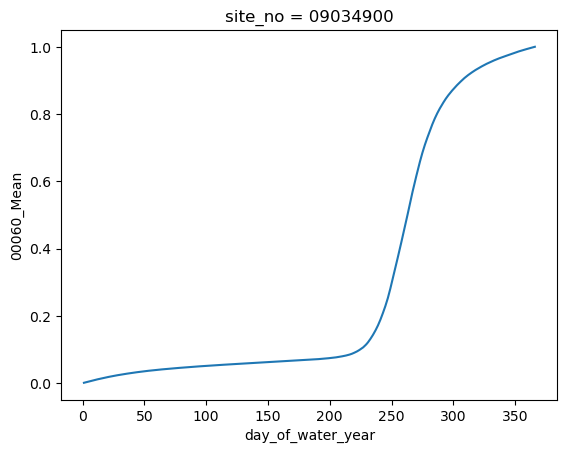

In [39]:
(water_year_mean_flow.cumsum(dim='day_of_water_year')/water_year_mean_flow.sum(dim='day_of_water_year')).isel(site_no=0).plot()

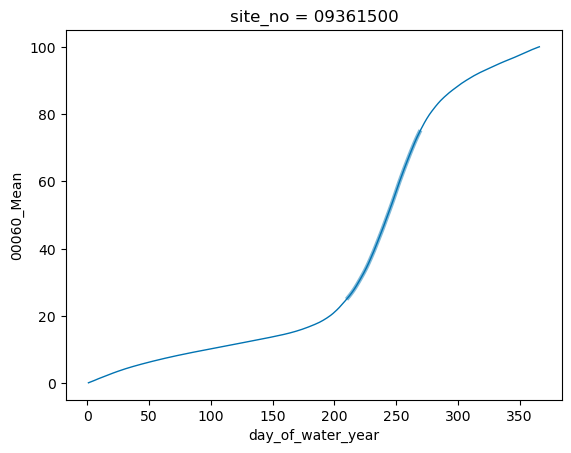

In [60]:
tmp_ds = (water_year_mean_flow.cumsum(dim='day_of_water_year')/water_year_mean_flow.sum(dim='day_of_water_year') * 100).isel(site_no=site)

tmp_ds.plot(label=water_year_mean_flow.site_no.values[site], color=colors[site], lw=1)
# create a filter for the inter quartile range
iqr_filter = (tmp_ds >= 25) & (tmp_ds <= 75)
# apply the filer to tmp_ds
tmp_ds.where(iqr_filter, drop=True).plot(lw=3, alpha=0.5,color=colors[site],)

Text(0.5, 1.0, 'Cumulative Distribution of Annual Streamflow')

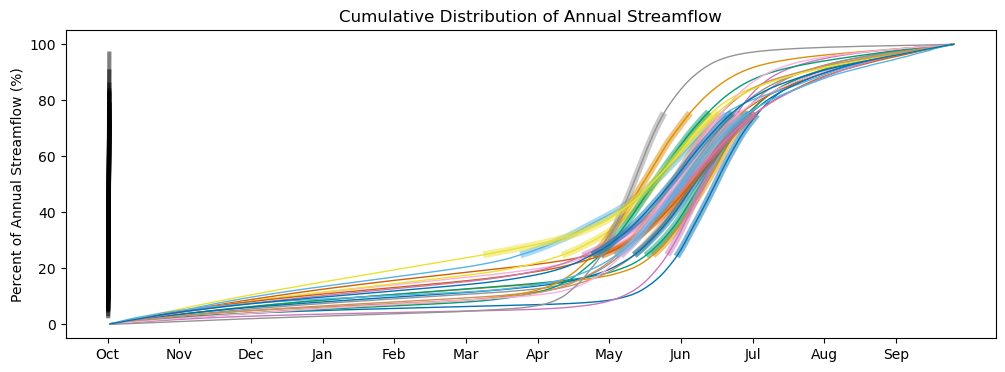

In [61]:
# create the figure
fig = plt.figure(figsize=(12,4))
# iterate through all sites and plot the above cumulative distribution
# create a list of colors, one for each site
colors = sns.color_palette('colorblind', len(water_year_mean_flow.site_no))

for site in range(len(water_year_mean_flow.site_no)):
    tmp_ds = (water_year_mean_flow.cumsum(dim='day_of_water_year')/water_year_mean_flow.sum(dim='day_of_water_year') * 100).isel(site_no=site)

    tmp_ds.plot(label=water_year_mean_flow.site_no.values[site], color=colors[site], lw=1)
    # create a filter for the inter quartile range
    iqr_filter = (tmp_ds >= 25) & (tmp_ds <= 75)
    # apply the filer to tmp_ds
    tmp_ds.where(iqr_filter, drop=True).plot(lw=5, alpha=0.5,color=colors[site],)
    # adda wider line for the interquartile range
    (water_year_mean_flow.cumsum(dim='day_of_water_year')/water_year_mean_flow.sum(dim='day_of_water_year') * 100).isel(site_no=site).quantile([0.25,0.75]).unstack().plot(linewidth=3, color='k', alpha=0.5)
# make the x-axis a an axis of months
plt.xticks(np.arange(0,366,31),['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']);
# make the y-axis a percentage
plt.ylabel('Percent of Annual Streamflow (%)')
# remove the x-label
plt.xlabel('')
# make the title "Cumulative Distribution of Annual Streamflow"
plt.title('Cumulative Distribution of Annual Streamflow')
